**Rozdział 17. Autokodery i sieci GAN**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 17._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza i TensorFlow 2.0 lub nowszy.

In [1]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version istnieje jedynie w środowisku Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# Wymagany moduł TensorFlow ≥2.0
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("Nie wykryto procesora graficznego. Bez niego komórki LSTM i sieci splotowe mogą działać bardzo powoli.")
    if IS_COLAB:
        print("Kliknij Runtime > Change runtime i wybierz akcelerator graficzny.")

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)
tf.random.set_seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R17"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow 2.x selected.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Dodatkowa funkcja służąca do wyświetlania czarno-białych obrazów o rozmiarze 28x28 pikseli:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Analiza PCA z autokoderem liniowym

Tworzymy trójwymiarowy zestaw danych:

In [0]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Stwórzmy teraz autokoder...

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Train on 60 samples
Epoch 1/20
60/60 [==============================] - 2s 33ms/sample - loss: 0.3064
Epoch 2/20
60/60 [==============================] - 0s 145us/sample - loss: 0.3797
Epoch 3/20
60/60 [==============================] - 0s 158us/sample - loss: 0.1454
Epoch 4/20
60/60 [==============================] - 0s 163us/sample - loss: 0.0872
Epoch 5/20
60/60 [==============================] - 0s 172us/sample - loss: 0.0658
Epoch 6/20
60/60 [==============================] - 0s 172us/sample - loss: 0.0464
Epoch 7/20
60/60 [==============================] - 0s 162us/sample - loss: 0.0356
Epoch 8/20
60/60 [==============================] - 0s 179us/sample - loss: 0.0238
Epoch 9/20
60/60 [==============================] - 0s 180us/sample - loss: 0.0225
Epoch 10/20
60/60 [==============================] - 0s 184us/sample - loss: 0.0093
Epoch 11/20
60/60 [==============================] - 0s 137us/sample - loss: 0.0068
Epoch 12/20
60/60 [==============================] - 0s 177us/samp

In [0]:
codings = encoder.predict(X_train)

Zapisywanie rysunku r_17_2


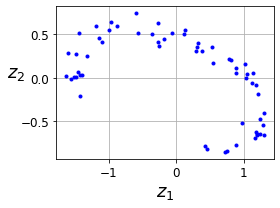

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("r_17_2")
plt.show()

# Autokodery stosowe

Skorzystajmy z zestawu danych MNIST:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4423680/4422102 [==============================] - 0s 0us/step


## Uczenie wszystkich warstw jednocześnie

Stwórzmy autokoder stosowy zawierający trzy warstwy ukryte i jedną warstwę wyjściową (tj. dwa autokodery stosowe).

In [0]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 6s 107us/sample - loss: 0.3390 - rounded_accuracy: 0.8860 - val_loss: 0.3111 - val_rounded_accuracy: 0.9129
Epoch 2/20
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3047 - val_rounded_accuracy: 0.9201
Epoch 3/20
55000/55000 [==============================] - 5s 98us/sample - loss: 0.2989 - rounded_accuracy: 0.9212 - val_loss: 0.3033 - val_rounded_accuracy: 0.9119
Epoch 4/20
55000/55000 [==============================] - 5s 96us/sample - loss: 0.2950 - rounded_accuracy: 0.9246 - val_loss: 0.2944 - val_rounded_accuracy: 0.9278
Epoch 5/20
55000/55000 [==============================] - 5s 98us/sample - loss: 0.2925 - rounded_accuracy: 0.9268 - val_loss: 0.2924 - val_rounded_accuracy: 0.9275
Epoch 6/20
55000/55000 [==============================] - 5s 96us/sample - loss: 0.2908 - rounded_accuracy: 0.9281 - val_loss

Funkcja przetwarza kilka obrazów testowych przez autokoder i wyświetla oryginalne obrazy, a także ich rekonstrukcje:

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Zapisywanie rysunku r_17_4


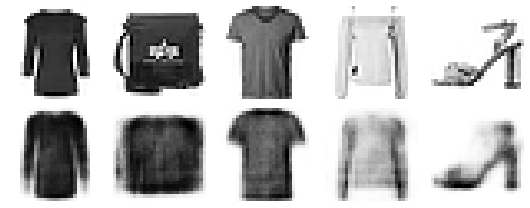

In [12]:
show_reconstructions(stacked_ae)
save_fig("r_17_4")

# Wizualizowanie zestawu danych Fashion MNIST

In [0]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

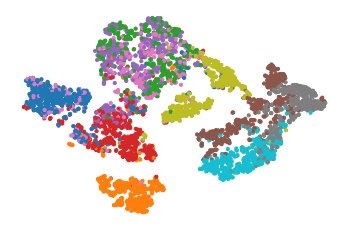

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Poprawmy trochę ten diagram:

Zapisywanie rysunku r_17_5


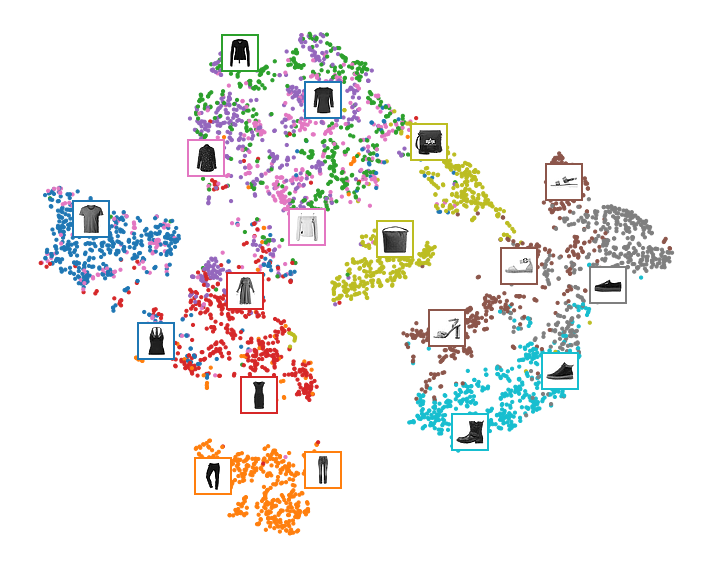

In [15]:
# zaadaptowany ze strony https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # jeżeli znajduje się wystarczająco daleko od pozostałych obrazów
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("r_17_5")
plt.show()

## Wiązanie wag

Powszechnie spotykane jest wiązanie wag kodera z wagami dekodera poprzez wykorzystanie transpozycji wag kodera jako wag dekodera. W tym celu wykorzystamy niestandardową warstwę.

In [0]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="obciazenie",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 104us/sample - loss: 0.3268 - rounded_accuracy: 0.8960 - val_loss: 0.3024 - val_rounded_accuracy: 0.9208
Epoch 2/10
55000/55000 [==============================] - 5s 100us/sample - loss: 0.2974 - rounded_accuracy: 0.9225 - val_loss: 0.2975 - val_rounded_accuracy: 0.9271
Epoch 3/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.2918 - rounded_accuracy: 0.9277 - val_loss: 0.2969 - val_rounded_accuracy: 0.9259
Epoch 4/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.2889 - rounded_accuracy: 0.9304 - val_loss: 0.2899 - val_rounded_accuracy: 0.9322
Epoch 5/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.2867 - rounded_accuracy: 0.9322 - val_loss: 0.2867 - val_rounded_accuracy: 0.9337
Epoch 6/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.2851 - rounded_accuracy: 0.9338 - val_los

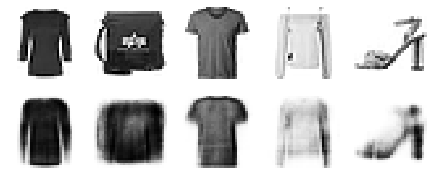

In [18]:
show_reconstructions(tied_ae)
plt.show()

## Uczenie autokoderów pojedynczo

In [0]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=[X_valid, X_valid])
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # równoważne .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(lr=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3446 - rounded_accuracy: 0.8873 - val_loss: 0.3123 - val_rounded_accuracy: 0.9148
Epoch 2/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.3040 - rounded_accuracy: 0.9202 - val_loss: 0.3008 - val_rounded_accuracy: 0.9248
Epoch 3/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.2951 - rounded_accuracy: 0.9284 - val_loss: 0.2936 - val_rounded_accuracy: 0.9314
Epoch 4/10
55000/55000 [==============================] - 5s 84us/sample - loss: 0.2893 - rounded_accuracy: 0.9340 - val_loss: 0.2889 - val_rounded_accuracy: 0.9357
Epoch 5/10
55000/55000 [==============================] - 5s 85us/sample - loss: 0.2855 - rounded_accuracy: 0.9376 - val_loss: 0.2859 - val_rounded_accuracy: 0.9387
Epoch 6/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.2829 - rounded_accuracy: 0.9401 - val_loss:

In [0]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

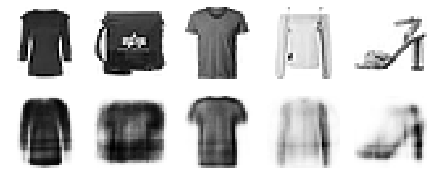

In [22]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [23]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(lr=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 100us/sample - loss: 0.2847 - rounded_accuracy: 0.9366 - val_loss: 0.2863 - val_rounded_accuracy: 0.9366
Epoch 2/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.2844 - rounded_accuracy: 0.9369 - val_loss: 0.2861 - val_rounded_accuracy: 0.9369
Epoch 3/10
55000/55000 [==============================] - 5s 95us/sample - loss: 0.2842 - rounded_accuracy: 0.9371 - val_loss: 0.2859 - val_rounded_accuracy: 0.9370
Epoch 4/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.2840 - rounded_accuracy: 0.9373 - val_loss: 0.2858 - val_rounded_accuracy: 0.9370
Epoch 5/10
55000/55000 [==============================] - 5s 91us/sample - loss: 0.2839 - rounded_accuracy: 0.9374 - val_loss: 0.2857 - val_rounded_accuracy: 0.9373
Epoch 6/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.2838 - rounded_accuracy: 0.9375 - val_loss

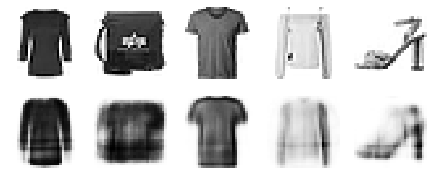

In [24]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## Zastępowanie warstw gęstych warstwami splotowymi

Stwórzmy autokoder stosowy zawierający trzy warstwy ukryte i jedną warstwę wyjściową (tj. dwa autokodery stosowe).

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 13s 228us/sample - loss: 0.3018 - rounded_accuracy: 0.9184 - val_loss: 0.2797 - val_rounded_accuracy: 0.9392
Epoch 2/5
55000/55000 [==============================] - 7s 129us/sample - loss: 0.2755 - rounded_accuracy: 0.9413 - val_loss: 0.2756 - val_rounded_accuracy: 0.9435
Epoch 3/5
55000/55000 [==============================] - 7s 131us/sample - loss: 0.2706 - rounded_accuracy: 0.9463 - val_loss: 0.2726 - val_rounded_accuracy: 0.9455
Epoch 4/5
55000/55000 [==============================] - 7s 135us/sample - loss: 0.2681 - rounded_accuracy: 0.9490 - val_loss: 0.2677 - val_rounded_accuracy: 0.9512
Epoch 5/5
55000/55000 [==============================] - 7s 134us/sample - loss: 0.2663 - rounded_accuracy: 0.9509 - val_loss: 0.2664 - val_rounded_accuracy: 0.9526


In [26]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)        

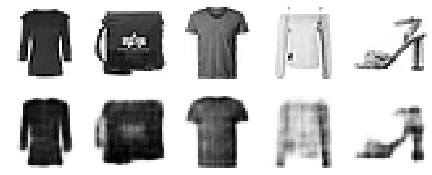

In [27]:
show_reconstructions(conv_ae)
plt.show()

# Autokodery rekurencyjne

In [0]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [29]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 18s 335us/sample - loss: 0.5191 - rounded_accuracy: 0.7484 - val_loss: 0.4583 - val_rounded_accuracy: 0.8129
Epoch 2/10
55000/55000 [==============================] - 15s 278us/sample - loss: 0.4053 - rounded_accuracy: 0.8431 - val_loss: 0.3740 - val_rounded_accuracy: 0.8665
Epoch 3/10
55000/55000 [==============================] - 15s 274us/sample - loss: 0.3656 - rounded_accuracy: 0.8708 - val_loss: 0.3582 - val_rounded_accuracy: 0.8789
Epoch 4/10
55000/55000 [==============================] - 15s 277us/sample - loss: 0.3511 - rounded_accuracy: 0.8805 - val_loss: 0.3449 - val_rounded_accuracy: 0.8860
Epoch 5/10
55000/55000 [==============================] - 15s 277us/sample - loss: 0.3407 - rounded_accuracy: 0.8873 - val_loss: 0.3377 - val_rounded_accuracy: 0.8866
Epoch 6/10
55000/55000 [==============================] - 15s 278us/sample - loss: 0.3335 - rounded_accuracy: 0.8922

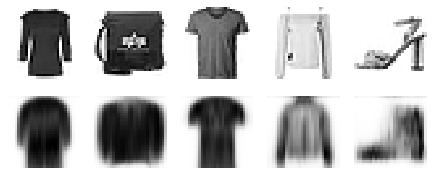

In [30]:
show_reconstructions(recurrent_ae)
plt.show()

# Odszumiające autokodery stosowe

Wprowadźmy szum gaussowski:

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.3513 - rounded_accuracy: 0.8763 - val_loss: 0.3179 - val_rounded_accuracy: 0.9066
Epoch 2/10
55000/55000 [==============================] - 5s 94us/sample - loss: 0.3126 - rounded_accuracy: 0.9093 - val_loss: 0.3079 - val_rounded_accuracy: 0.9165
Epoch 3/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3058 - rounded_accuracy: 0.9150 - val_loss: 0.3030 - val_rounded_accuracy: 0.9191
Epoch 4/10
55000/55000 [==============================] - 5s 93us/sample - loss: 0.3021 - rounded_accuracy: 0.9183 - val_loss: 0.2999 - val_rounded_accuracy: 0.9232
Epoch 5/10
55000/55000 [==============================] - 5s 92us/sample - loss: 0.2991 - rounded_accuracy: 0.9209 - val_loss: 0.2969 - val_rounded_accuracy: 0.9253
Epoch 6/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.2968 - rounded_accuracy: 0.9230 - val_loss

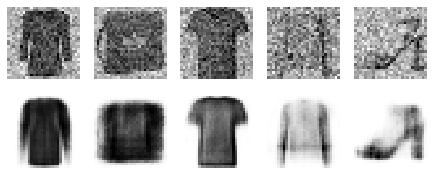

In [32]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

Wprowadźmy porzucanie:

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 105us/sample - loss: 0.3572 - rounded_accuracy: 0.8703 - val_loss: 0.3193 - val_rounded_accuracy: 0.9052
Epoch 2/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3117 - val_rounded_accuracy: 0.9115
Epoch 3/10
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3128 - rounded_accuracy: 0.9076 - val_loss: 0.3087 - val_rounded_accuracy: 0.9144
Epoch 4/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3096 - rounded_accuracy: 0.9100 - val_loss: 0.3049 - val_rounded_accuracy: 0.9164
Epoch 5/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3070 - rounded_accuracy: 0.9120 - val_loss: 0.3023 - val_rounded_accuracy: 0.9178
Epoch 6/10
55000/55000 [==============================] - 6s 100us/sample - loss: 0.3052 - rounded_accuracy: 0.9134 - val_los

Zapisywanie rysunku r_17_9


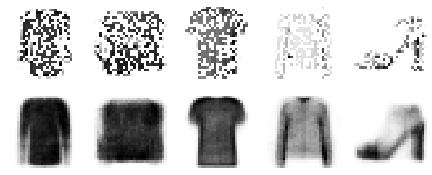

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("r_17_9", tight_layout=False)

# Autokoder rzadki

Stwórzmy prosty autokoder stosowy, którego będziemy mogli porównywać z autokoderami rzadkimi. Tym razem w warstwie kodowania wprowadzimy sigmoidalną funkcję aktywacji, dzięki czemu wartości kodowania będą mieściły się w zakresie od 0 do 1:

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 107us/sample - loss: 0.4332 - rounded_accuracy: 0.7944 - val_loss: 0.3777 - val_rounded_accuracy: 0.8503
Epoch 2/10
55000/55000 [==============================] - 6s 101us/sample - loss: 0.3614 - rounded_accuracy: 0.8667 - val_loss: 0.3511 - val_rounded_accuracy: 0.8785
Epoch 3/10
55000/55000 [==============================] - 5s 99us/sample - loss: 0.3403 - rounded_accuracy: 0.8860 - val_loss: 0.3360 - val_rounded_accuracy: 0.8898
Epoch 4/10
55000/55000 [==============================] - 6s 106us/sample - loss: 0.3280 - rounded_accuracy: 0.8962 - val_loss: 0.3256 - val_rounded_accuracy: 0.9006
Epoch 5/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3215 - val_rounded_accuracy: 0.9018
Epoch 6/10
55000/55000 [==============================] - 5s 98us/sample - loss: 0.3178 - rounded_accuracy: 0.9037 - val_l

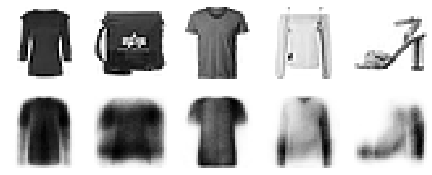

In [36]:
show_reconstructions(simple_ae)
plt.show()

Przygotujmy dwie funkcje umożliwiające wyświetlanie histogramów pobudzenia:

In [0]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [0]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Średnia całkowita = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Aktywacja")
    ax1.set_ylabel("% aktywacji")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Średnia aktywacja neuronu")
    ax2.set_ylabel("% neuronów")
    ax2.axis([0, 1, 0, height])

Wykorzystajmy te funkcje do wyświetlenia histogramów pobudzeń w warstwie kodowania. Histogram po lewej ukazuje rozkład wszystkich aktywacji. Widzimy, że zasadniczo najczęściej występują pobudzenia o wartościach zbliżonych do 0 i 1, co jest zgodne z nasycającą naturą funkcji sigmoidalnej. Histogram po prawej ukazuje rozkład średnich aktywacji neuronów: jak widać, średnie pobudzenie większości neuronów ma wartość bliską 0,5. Dzięki obydwu histogramom wiemy, że pobudzenie każdego neuronu ma wartość zbliżoną do 0 lub 1 i każda z tych wartości ma 50% szans na pojawienie się. Jednak niektóre neurony są pobudzone niemal przez cały czas (prawa strona prawego histogramu).

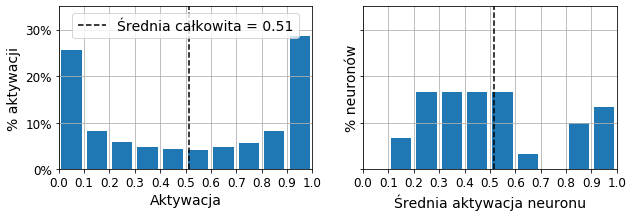

In [41]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

Dodajmy teraz w warstwie kodowania regularyzację $\ell_1$:

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Ewentualnie możesz dodać
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # w poprzedniej warstwie.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 7s 120us/sample - loss: 0.4311 - rounded_accuracy: 0.8128 - val_loss: 0.3809 - val_rounded_accuracy: 0.8564
Epoch 2/10
55000/55000 [==============================] - 6s 107us/sample - loss: 0.3691 - rounded_accuracy: 0.8687 - val_loss: 0.3639 - val_rounded_accuracy: 0.8750
Epoch 3/10
55000/55000 [==============================] - 6s 110us/sample - loss: 0.3546 - rounded_accuracy: 0.8799 - val_loss: 0.3504 - val_rounded_accuracy: 0.8859
Epoch 4/10
55000/55000 [==============================] - 6s 109us/sample - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3437 - val_rounded_accuracy: 0.8917
Epoch 5/10
55000/55000 [==============================] - 6s 110us/sample - loss: 0.3373 - rounded_accuracy: 0.8922 - val_loss: 0.3361 - val_rounded_accuracy: 0.8946
Epoch 6/10
55000/55000 [==============================] - 6s 109us/sample - loss: 0.3319 - rounded_accuracy: 0.8971 - val

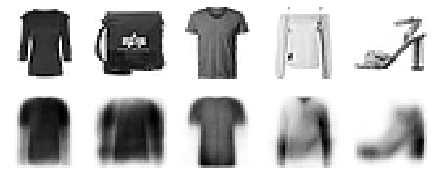

In [43]:
show_reconstructions(sparse_l1_ae)

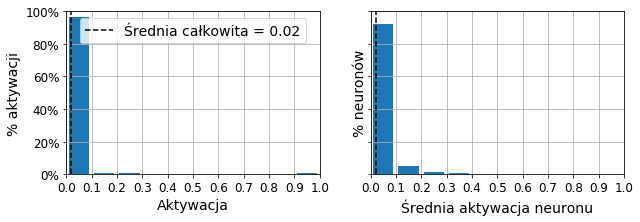

In [44]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

W celu zagwarantowania rzadkości dodajmy dywergencję KL jako funkcję straty, a także zastąpmy docelową rzadkość o wartości 0% wartością 10%:

Zapisywanie rysunku r_17_10


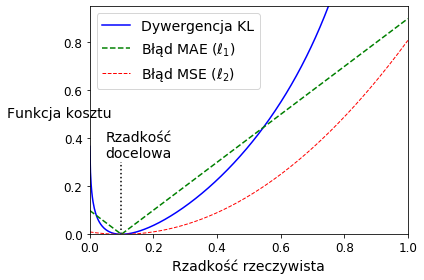

In [45]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Rzadkość\ndocelowa", fontsize=14)
plt.plot(q, kl_div, "b-", label="Dywergencja KL")
plt.plot(q, mae, "g--", label=r"Błąd MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"Błąd MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Rzadkość rzeczywista")
plt.ylabel("Funkcja kosztu", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("r_17_10")

In [0]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 137us/sample - loss: 0.4152 - rounded_accuracy: 0.8119 - val_loss: 0.3717 - val_rounded_accuracy: 0.8562
Epoch 2/10
55000/55000 [==============================] - 7s 126us/sample - loss: 0.3534 - rounded_accuracy: 0.8759 - val_loss: 0.3445 - val_rounded_accuracy: 0.8849
Epoch 3/10
55000/55000 [==============================] - 7s 126us/sample - loss: 0.3342 - rounded_accuracy: 0.8917 - val_loss: 0.3295 - val_rounded_accuracy: 0.8976
Epoch 4/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3214 - val_rounded_accuracy: 0.9037
Epoch 5/10
55000/55000 [==============================] - 7s 124us/sample - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9082
Epoch 6/10
55000/55000 [==============================] - 7s 126us/sample - loss: 0.3134 - rounded_accuracy: 0.9093 - val

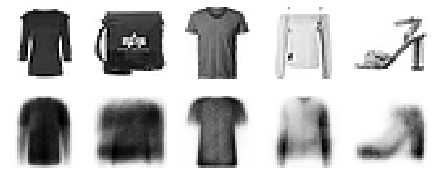

In [48]:
show_reconstructions(sparse_kl_ae)

Zapisywanie rysunku r_17_11


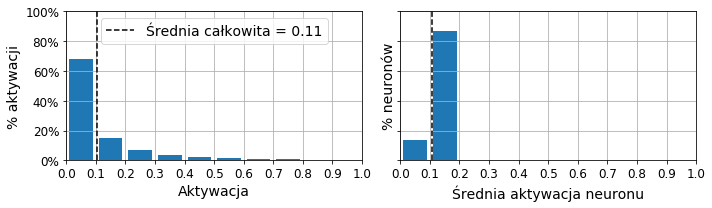

In [49]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("r_17_11")
plt.show()

# Autokoder wariacyjny

In [0]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [51]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3896 - rounded_accuracy: 0.8599 - val_loss: 0.3480 - val_rounded_accuracy: 0.8998
Epoch 2/25
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3429 - rounded_accuracy: 0.8973 - val_loss: 0.3376 - val_rounded_accuracy: 0.9059
Epoch 3/25
55000/55000 [==============================] - 3s 49us/sample - loss: 0.3328 - rounded_accuracy: 0.9051 - val_loss: 0.3345 - val_rounded_accuracy: 0.9022
Epoch 4/25
55000/55000 [==============================] - 3s 46us/sample - loss: 0.3279 - rounded_accuracy: 0.9091 - val_loss: 0.3293 - val_rounded_accuracy: 0.9068
Epoch 5/25
55000/55000 [==============================] - 3s 47us/sample - loss: 0.3248 - rounded_accuracy: 0.9114 - val_loss: 0.3239 - val_rounded_accuracy: 0.9131
Epoch 6/25
55000/55000 [==============================] - 3s 48us/sample - loss: 0.3225 - rounded_accuracy: 0.9133 - val_loss:

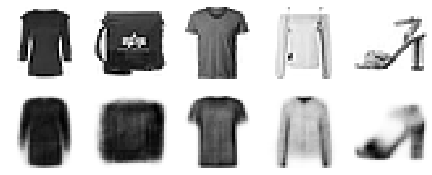

In [52]:
show_reconstructions(variational_ae)
plt.show()

## Generowanie obrazów przypominających zestaw Fashion MNIST

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Wygenerujmy kilka losowych kodowań, rozkodujmy je i wyświetlmy uzyskane obrazy:

Zapisywanie rysunku r_17_13


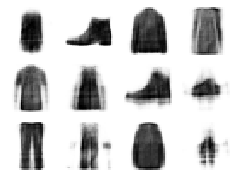

In [54]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("r_17_13", tight_layout=False)

Zrealizujmy teraz interpolację semantyczną pomiędzy tymi obrazami:

Zapisywanie rysunku r_17_14


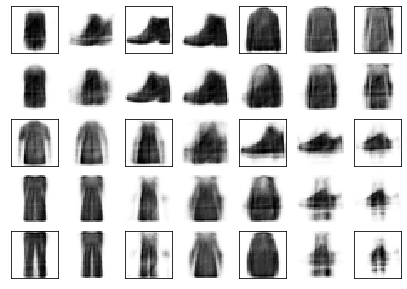

In [55]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("r_17_14", tight_layout=False)

# Generatywne sieci przeciwstawne

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [0]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoka numer {}/{}".format(epoch + 1, n_epochs))              # nieukazane w książce
        for X_batch in dataset:
            # Faza 1. Uczenie dyskryminatora
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # Faza 2. Uczenie generatora
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # nieukazane
        plt.show()                                                    # nieukazane

Epoka numer 1/1


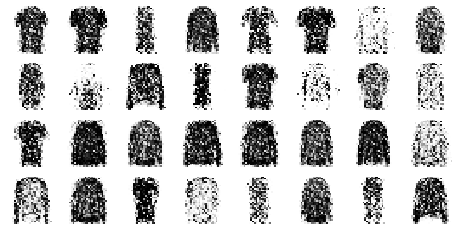

In [60]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Zapisywanie rysunku r_17_16


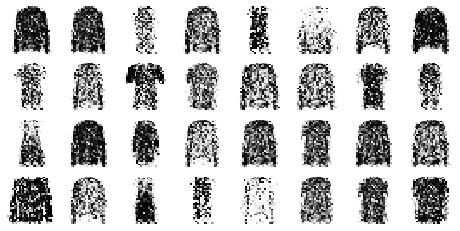

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("r_17_16", tight_layout=False)

Epoka numer 1/50


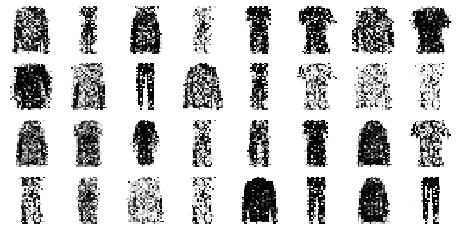

Epoka numer 2/50


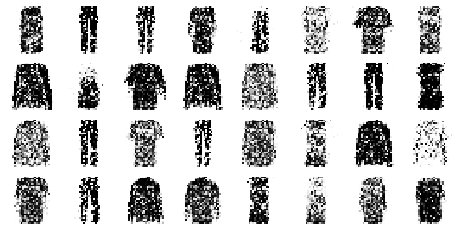

Epoka numer 3/50


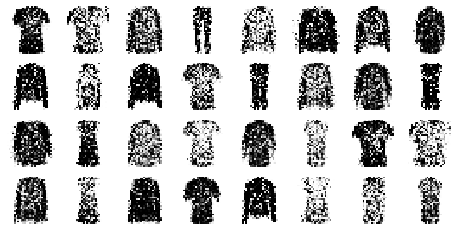

Epoka numer 4/50


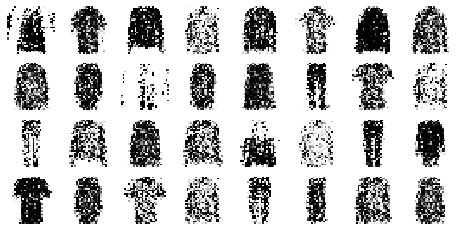

Epoka numer 5/50


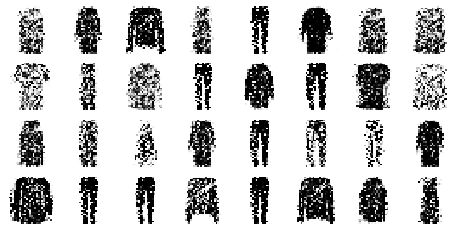

Epoka numer 6/50


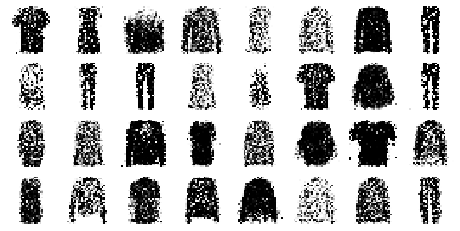

Epoka numer 7/50


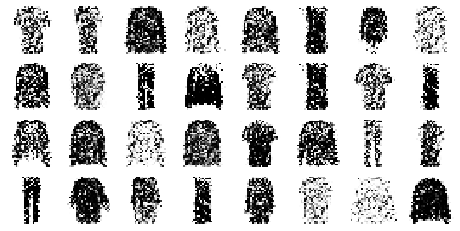

Epoka numer 8/50


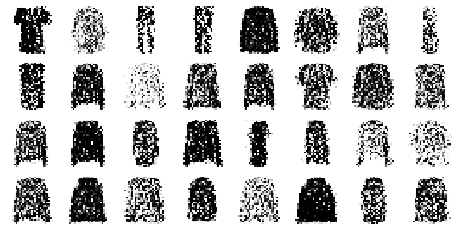

Epoka numer 9/50


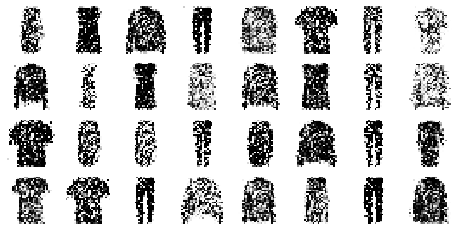

Epoka numer 10/50


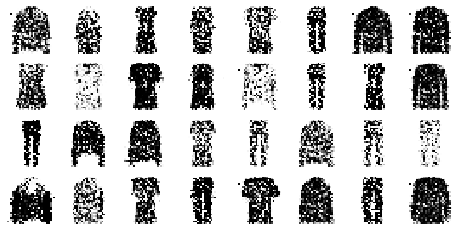

Epoka numer 11/50


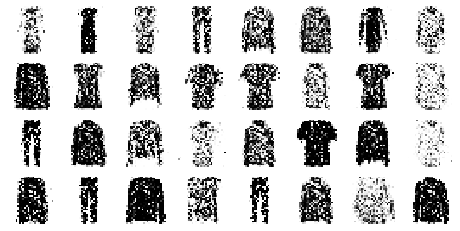

Epoka numer 12/50


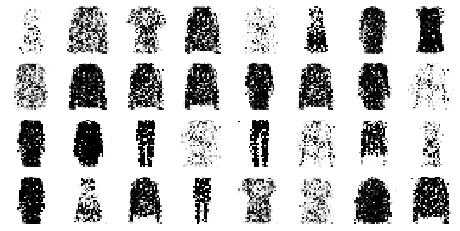

Epoka numer 13/50


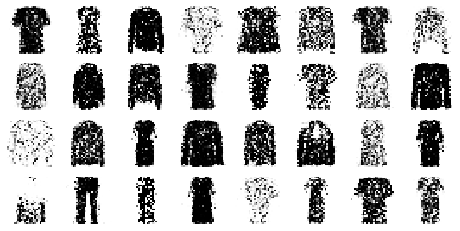

Epoka numer 14/50


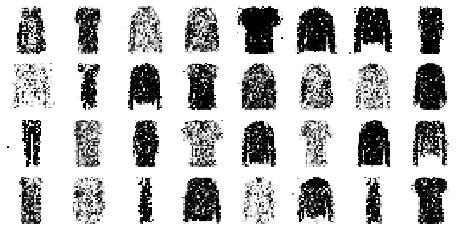

Epoka numer 15/50


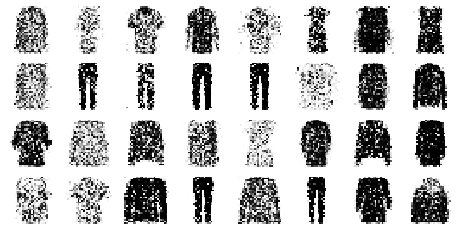

Epoka numer 16/50


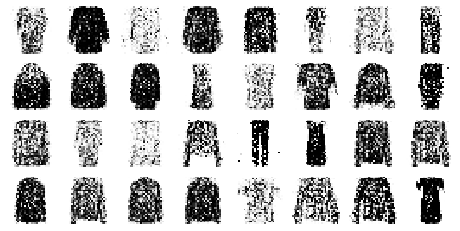

Epoka numer 17/50


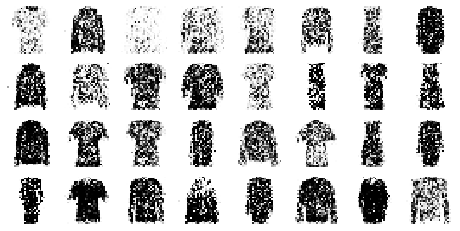

Epoka numer 18/50


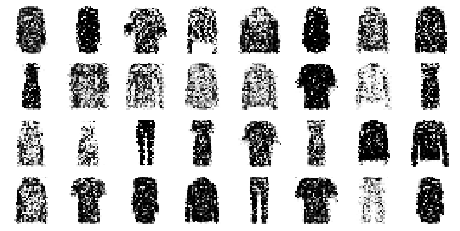

Epoka numer 19/50


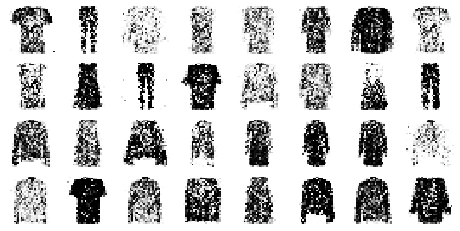

Epoka numer 20/50


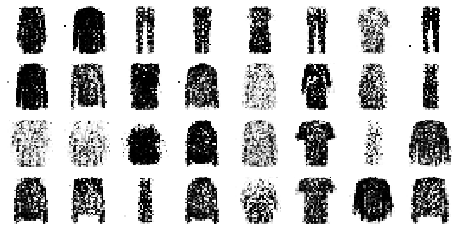

Epoka numer 21/50


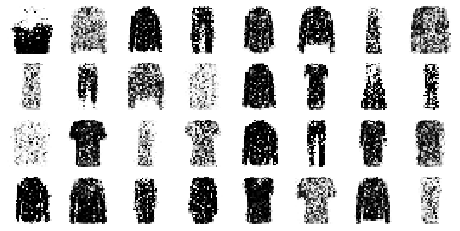

Epoka numer 22/50


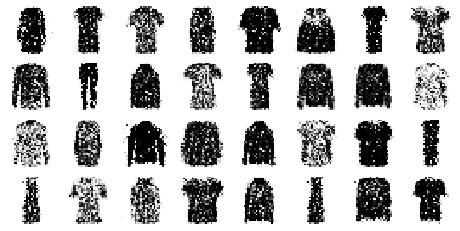

Epoka numer 23/50


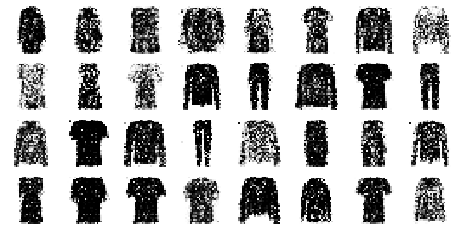

Epoka numer 24/50


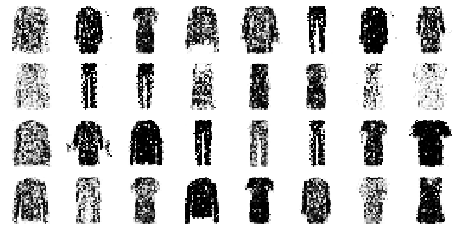

Epoka numer 25/50


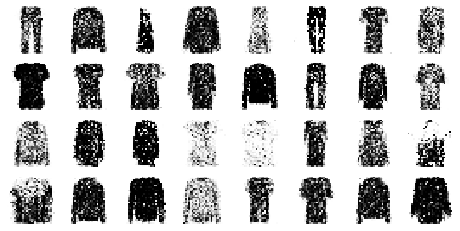

Epoka numer 26/50


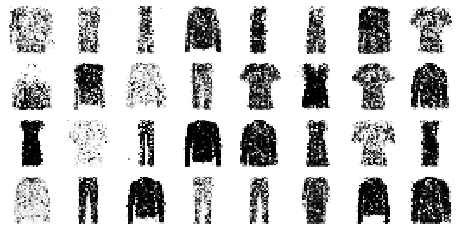

Epoka numer 27/50


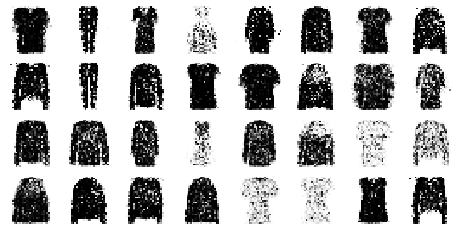

Epoka numer 28/50


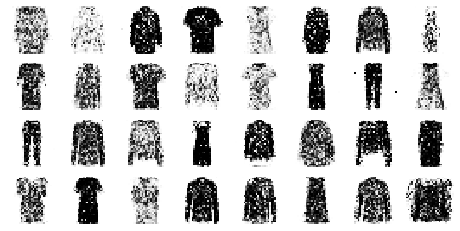

Epoka numer 29/50


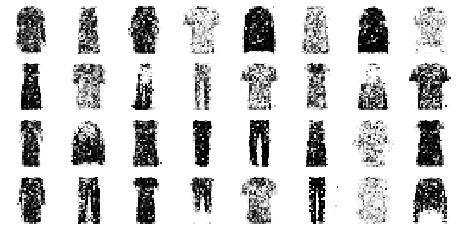

Epoka numer 30/50


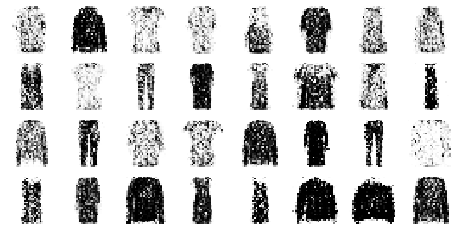

Epoka numer 31/50


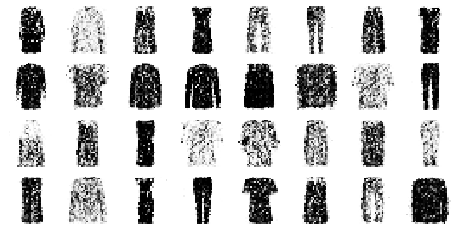

Epoka numer 32/50


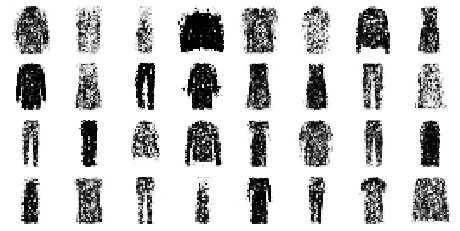

Epoka numer 33/50


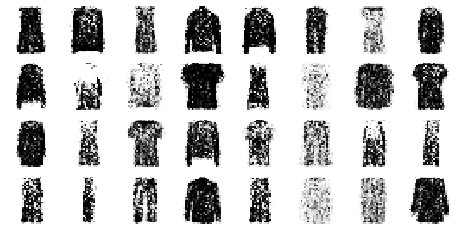

Epoka numer 34/50


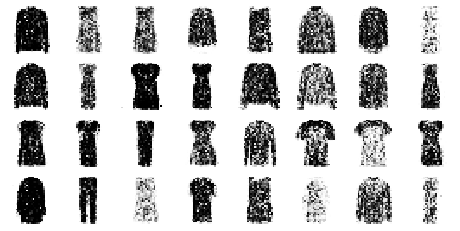

Epoka numer 35/50


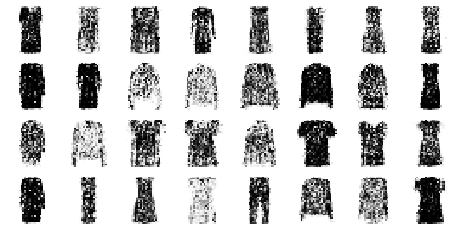

Epoka numer 36/50


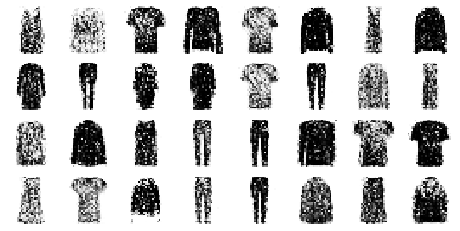

Epoka numer 37/50


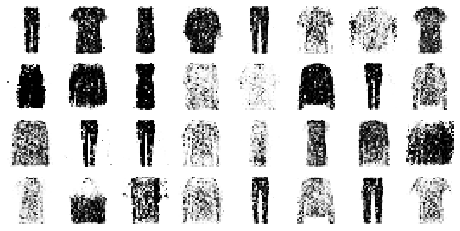

Epoka numer 38/50


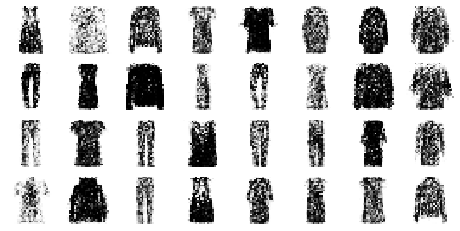

Epoka numer 39/50


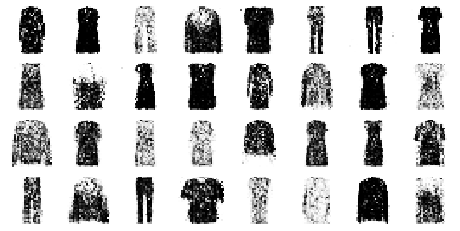

Epoka numer 40/50


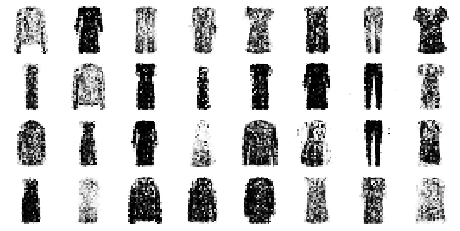

Epoka numer 41/50


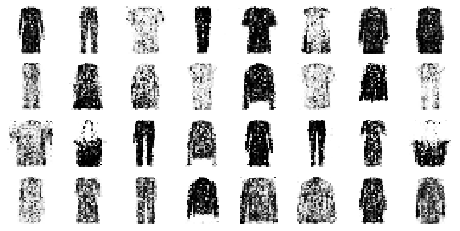

Epoka numer 42/50


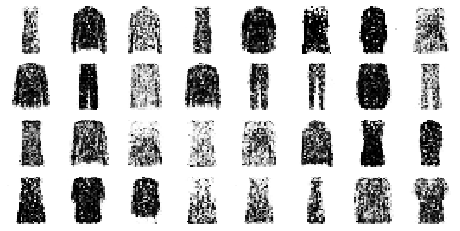

Epoka numer 43/50


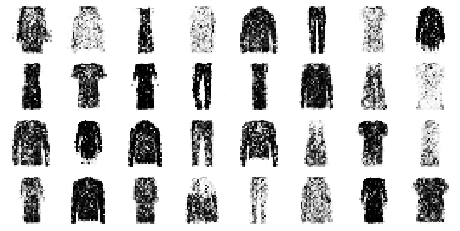

Epoka numer 44/50


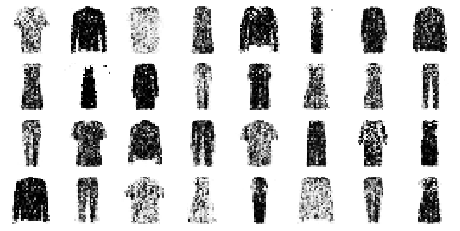

Epoka numer 45/50


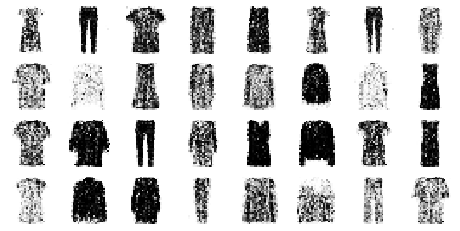

Epoka numer 46/50


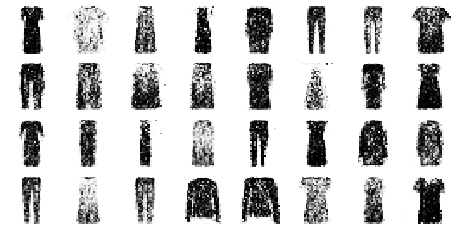

Epoka numer 47/50


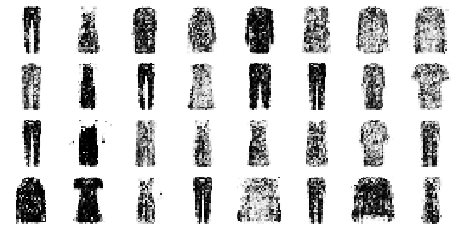

Epoka numer 48/50


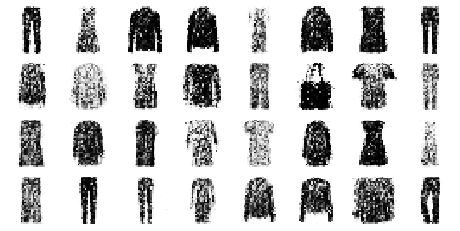

Epoka numer 49/50


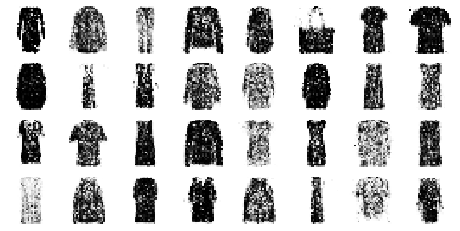

Epoka numer 50/50


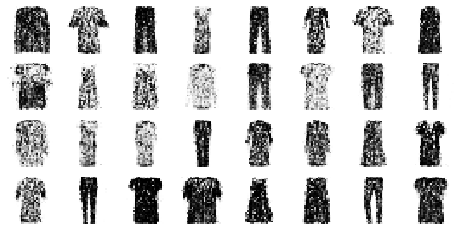

In [62]:
train_gan(gan, dataset, batch_size, codings_size)

# Głęboka, splotowa sieć GAN

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [0]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [0]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # zmienia rozmiar i skalę

In [0]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoka numer 1/50


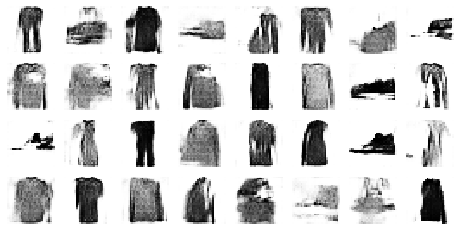

Epoka numer 2/50


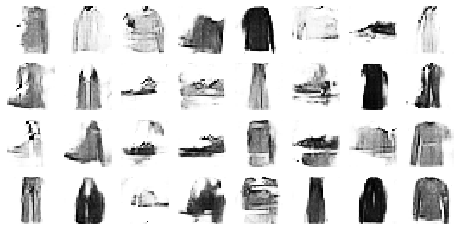

Epoka numer 3/50


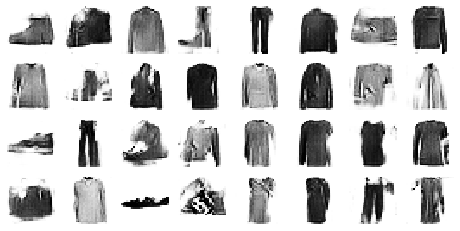

Epoka numer 4/50


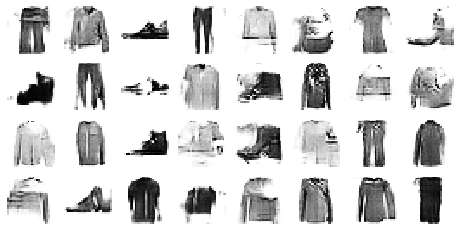

Epoka numer 5/50


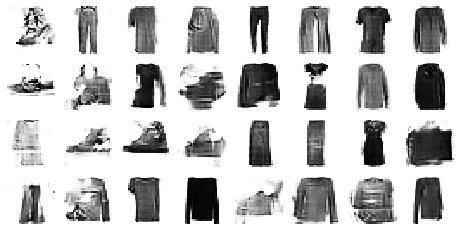

Epoka numer 6/50


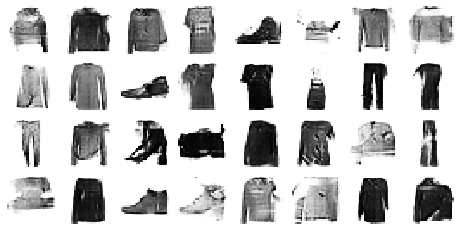

Epoka numer 7/50


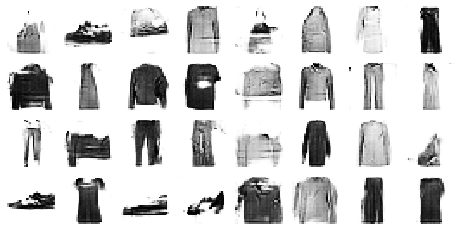

Epoka numer 8/50


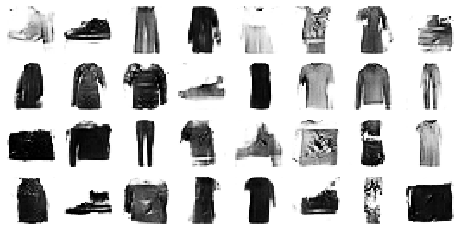

Epoka numer 9/50


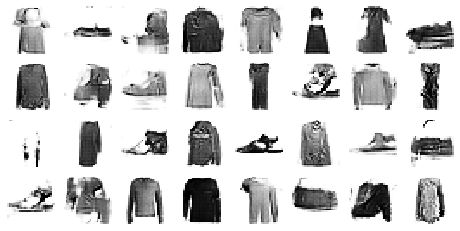

Epoka numer 10/50


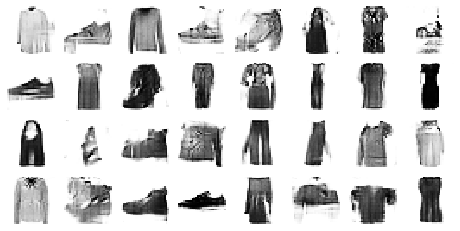

Epoka numer 11/50


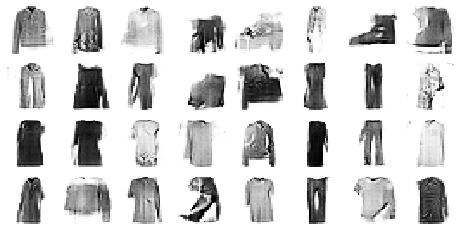

Epoka numer 12/50


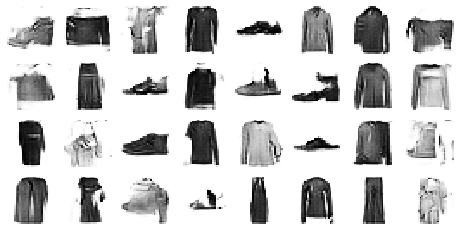

Epoka numer 13/50


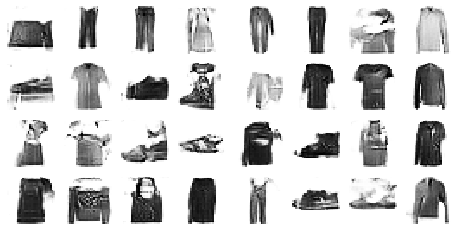

Epoka numer 14/50


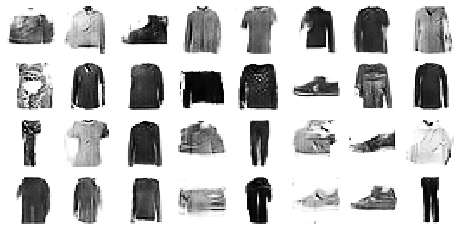

Epoka numer 15/50


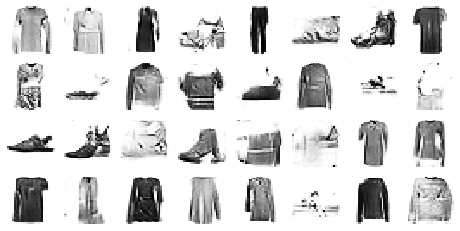

Epoka numer 16/50


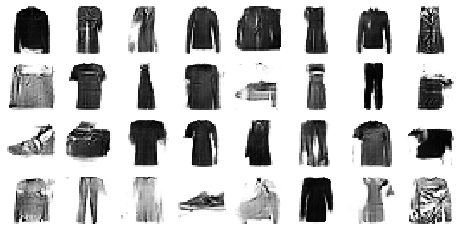

Epoka numer 17/50


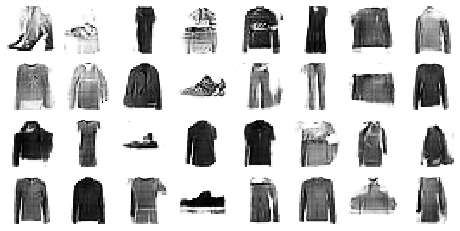

Epoka numer 18/50


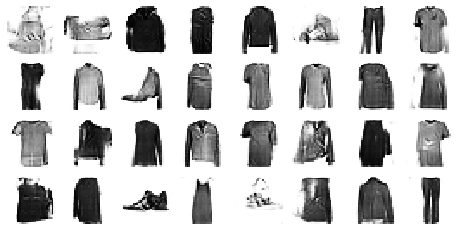

Epoka numer 19/50


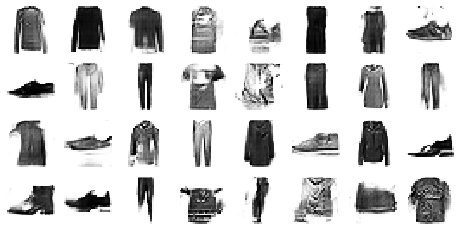

Epoka numer 20/50


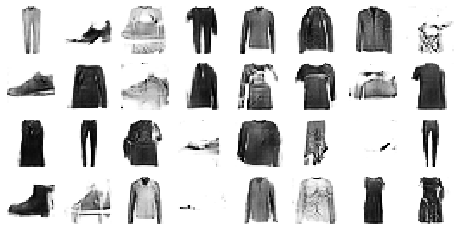

Epoka numer 21/50


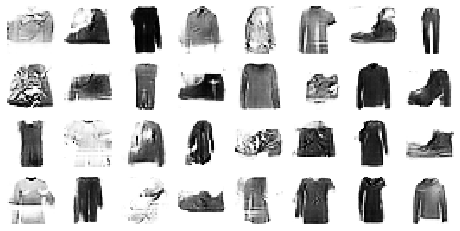

Epoka numer 22/50


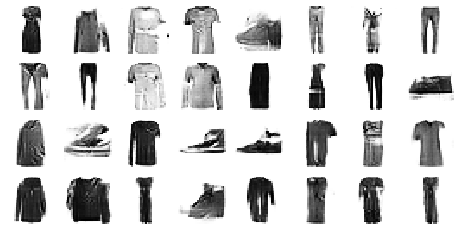

Epoka numer 23/50


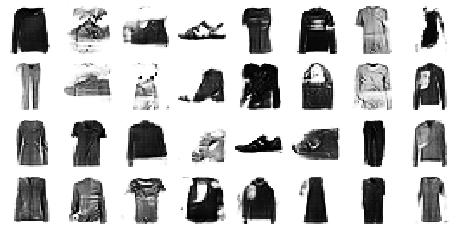

Epoka numer 24/50


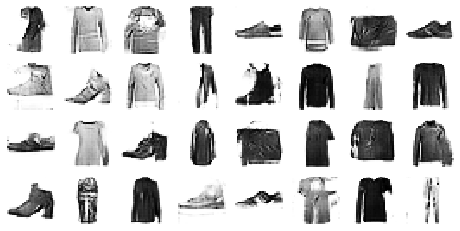

Epoka numer 25/50


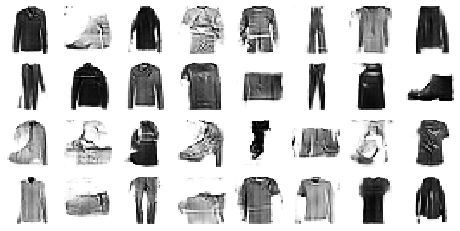

Epoka numer 26/50


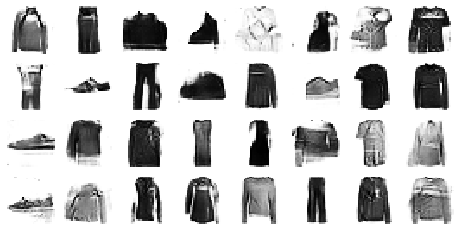

Epoka numer 27/50


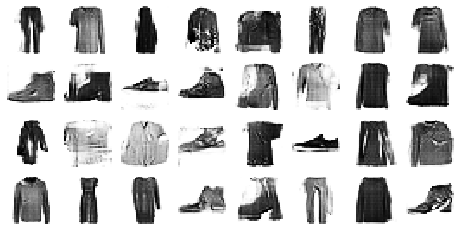

Epoka numer 28/50


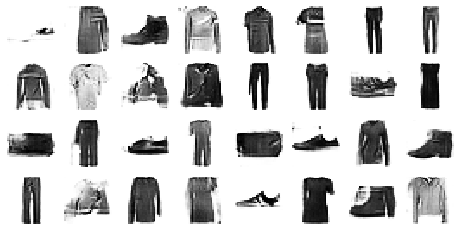

Epoka numer 29/50


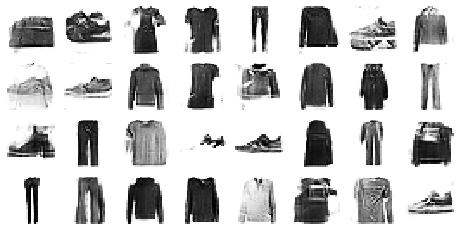

Epoka numer 30/50


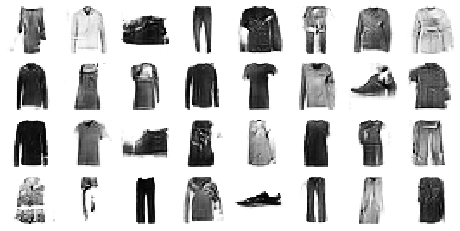

Epoka numer 31/50


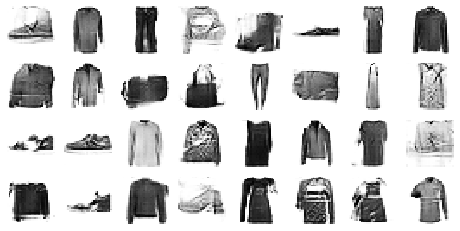

Epoka numer 32/50


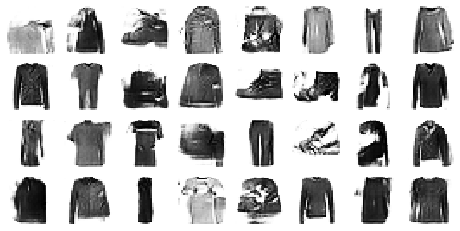

Epoka numer 33/50


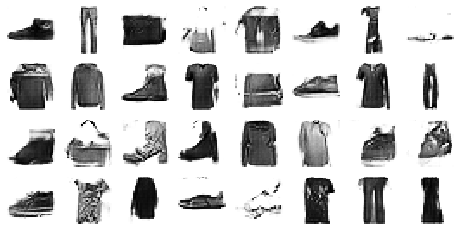

Epoka numer 34/50


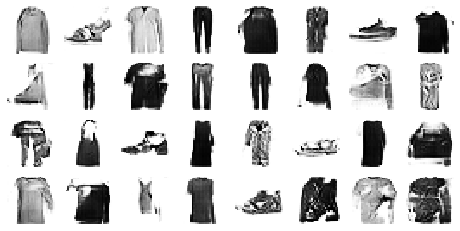

Epoka numer 35/50


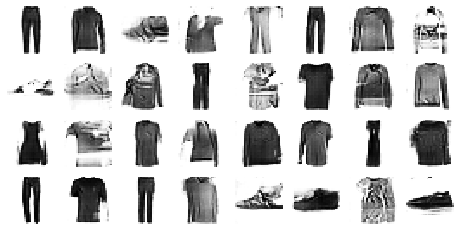

Epoka numer 36/50


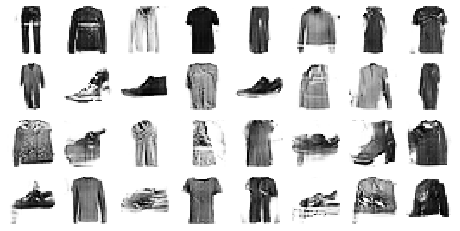

Epoka numer 37/50


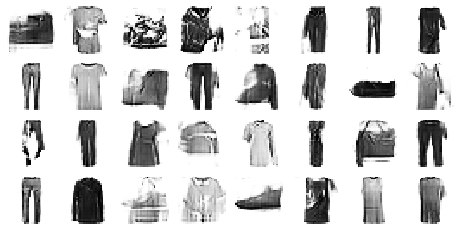

Epoka numer 38/50


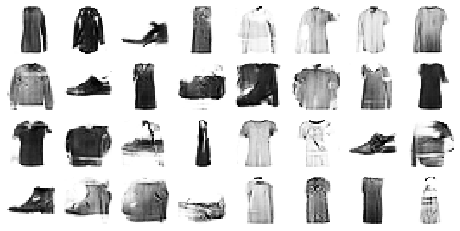

Epoka numer 39/50


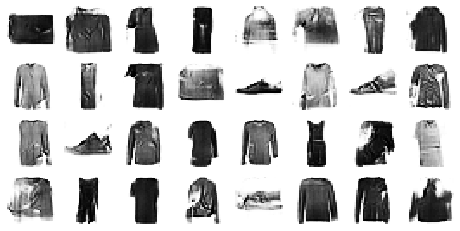

Epoka numer 40/50


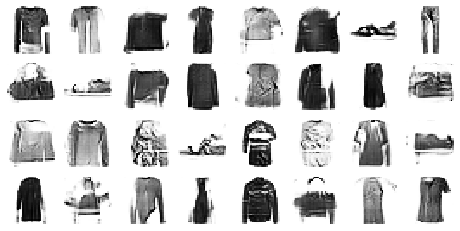

Epoka numer 41/50


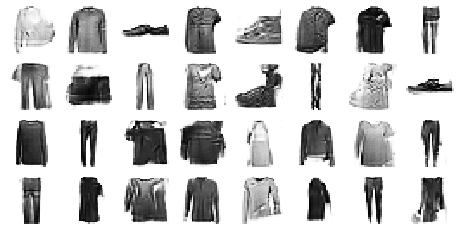

Epoka numer 42/50


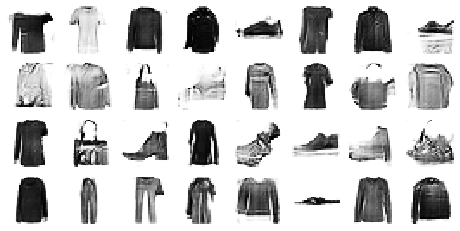

Epoka numer 43/50


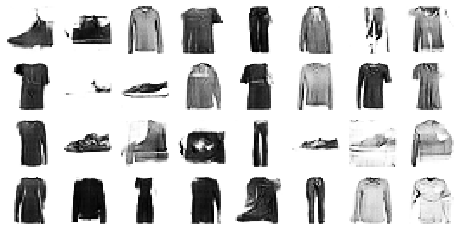

Epoka numer 44/50


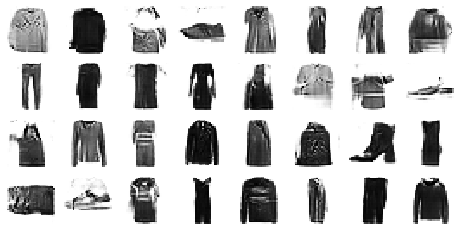

Epoka numer 45/50


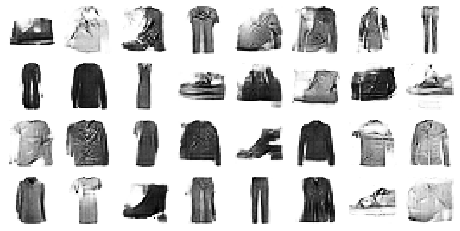

Epoka numer 46/50


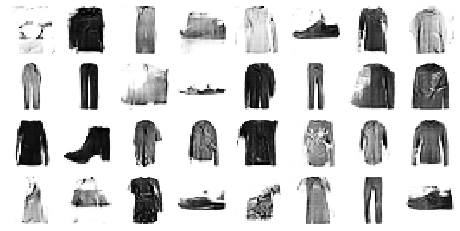

Epoka numer 47/50


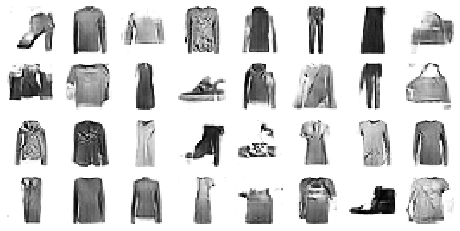

Epoka numer 48/50


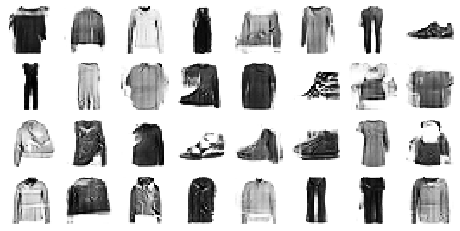

Epoka numer 49/50


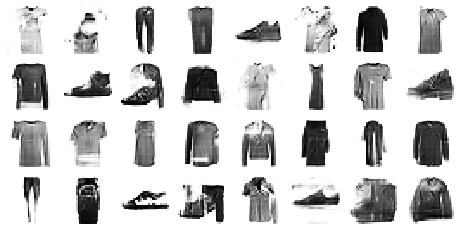

Epoka numer 50/50


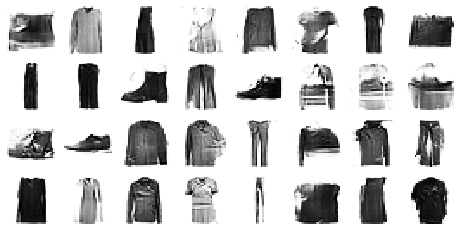

In [67]:
train_gan(gan, dataset, batch_size, codings_size)

Zapisywanie rysunku r_17_17


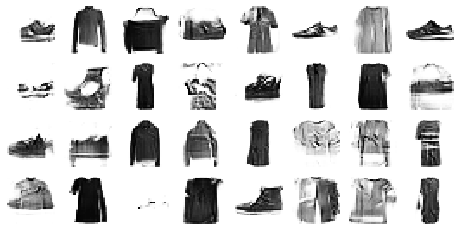

In [68]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("r_17_17", tight_layout=False)

# Rozwiązania ćwiczeń

## Nienadzorowane uczenie wstępne

Stwórzmy małą sieć neuronową, klasyfikującą obrazy MNIST:

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

X_train_small = X_train[:500]
y_train_small = y_train[:500]

classifier = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
classifier.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(lr=0.02),
                   metrics=["accuracy"])
history = classifier.fit(X_train_small, y_train_small, epochs=20, validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 3ms/sample - loss: 2.1965 - accuracy: 0.2480 - val_loss: 2.0234 - val_accuracy: 0.3148
Epoch 2/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.7927 - accuracy: 0.5180 - val_loss: 1.5677 - val_accuracy: 0.6280
Epoch 3/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.3931 - accuracy: 0.6360 - val_loss: 1.2556 - val_accuracy: 0.5482
Epoch 4/20
500/500 [==============================] - 1s 2ms/sample - loss: 1.1168 - accuracy: 0.6620 - val_loss: 0.9990 - val_accuracy: 0.6892
Epoch 5/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.9421 - accuracy: 0.7360 - val_loss: 1.1235 - val_accuracy: 0.6208
Epoch 6/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.8392 - accuracy: 0.7240 - val_loss: 0.8985 - val_accuracy: 0.6778
Epoch 7/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.7738 - accu

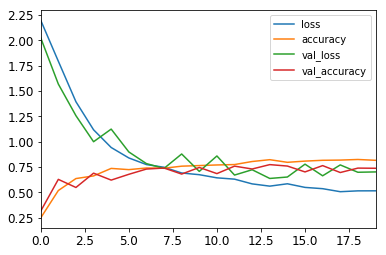

In [0]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder_clone = keras.models.clone_model(conv_encoder)

pretrained_clf = keras.models.Sequential([
    conv_encoder_clone,
    keras.layers.Flatten(),
    keras.layers.Dense(20, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])

In [0]:
conv_encoder_clone.trainable = False
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=30,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/30
500/500 [==============================] - 1s 3ms/sample - loss: 2.3174 - accuracy: 0.1820 - val_loss: 2.2350 - val_accuracy: 0.2156
Epoch 2/30
500/500 [==============================] - 1s 2ms/sample - loss: 2.1829 - accuracy: 0.2760 - val_loss: 2.1267 - val_accuracy: 0.3650
Epoch 3/30
500/500 [==============================] - 1s 2ms/sample - loss: 2.0852 - accuracy: 0.3880 - val_loss: 2.0370 - val_accuracy: 0.4378
Epoch 4/30
500/500 [==============================] - 1s 2ms/sample - loss: 1.9953 - accuracy: 0.4500 - val_loss: 1.9513 - val_accuracy: 0.5028
Epoch 5/30
500/500 [==============================] - 1s 2ms/sample - loss: 1.9117 - accuracy: 0.5860 - val_loss: 1.8742 - val_accuracy: 0.5610
Epoch 6/30
500/500 [==============================] - 1s 1ms/sample - loss: 1.8310 - accuracy: 0.6180 - val_loss: 1.7963 - val_accuracy: 0.6242
Epoch 7/30
500/500 [==============================] - 1s 1ms/sample - loss: 1.7526 - accu

In [0]:
conv_encoder_clone.trainable = True
pretrained_clf.compile(loss="sparse_categorical_crossentropy",
                       optimizer=keras.optimizers.SGD(lr=0.02),
                       metrics=["accuracy"])
history = pretrained_clf.fit(X_train_small, y_train_small, epochs=20,
                             validation_data=[X_valid, y_valid])

Train on 500 samples, validate on 5000 samples
Epoch 1/20
500/500 [==============================] - 1s 3ms/sample - loss: 0.8479 - accuracy: 0.7360 - val_loss: 0.8023 - val_accuracy: 0.7154
Epoch 2/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.7508 - accuracy: 0.7480 - val_loss: 0.7908 - val_accuracy: 0.7062
Epoch 3/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6956 - accuracy: 0.7700 - val_loss: 0.8156 - val_accuracy: 0.7006
Epoch 4/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6806 - accuracy: 0.7700 - val_loss: 0.7408 - val_accuracy: 0.7244
Epoch 5/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6563 - accuracy: 0.7700 - val_loss: 0.6731 - val_accuracy: 0.7540
Epoch 6/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6262 - accuracy: 0.7920 - val_loss: 0.7332 - val_accuracy: 0.7316
Epoch 7/20
500/500 [==============================] - 1s 2ms/sample - loss: 0.6039 - accu

## Mieszanie za pomocą autokodera binarnego

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.4999 - accuracy: 0.4830 - val_loss: 0.4866 - val_accuracy: 0.4815
Epoch 2/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4780 - accuracy: 0.4892 - val_loss: 0.4768 - val_accuracy: 0.4540
Epoch 3/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.4284 - accuracy: 0.4889 - val_loss: 0.4229 - val_accuracy: 0.4757
Epoch 4/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.4088 - accuracy: 0.4895 - val_loss: 0.4195 - val_accuracy: 0.4752
Epoch 5/10
55000/55000 [==============================] - 4s 70us/sample - loss: 0.4018 - accuracy: 0.4900 - val_loss: 0.4166 - val_accuracy: 0.4751
Epoch 6/10
55000/55000 [==============================] - 4s 69us/sample - loss: 0.3971 - accuracy: 0.4905 - val_loss: 0.4170 - val_accuracy: 0.4746
Epoch 7/10
55000/55000 [==============================] -

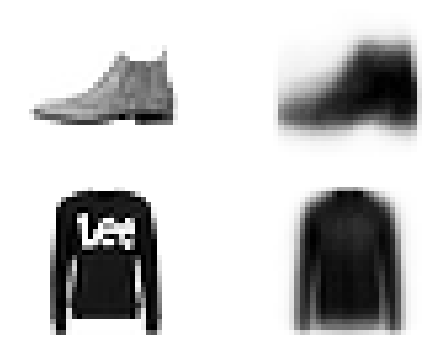

In [0]:
show_reconstructions(hashing_ae)
plt.show()

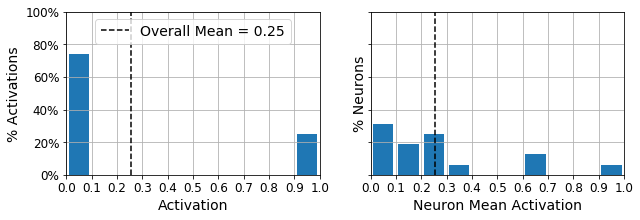

In [0]:
plot_activations_histogram(hashing_encoder)
plt.show()

In [0]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

0000100100000001
0000100100000000
0000100100000001
0000100000000000
0000100000100000
...


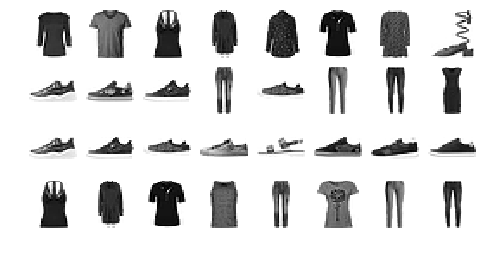

In [0]:
n_bits = 4
n_images = 8
plt.figure(figsize=(n_images, n_bits))
for bit_index in range(n_bits):
    in_bucket = (hashes & 2**bit_index != 0)
    for index, image in zip(range(n_images), X_valid[in_bucket]):
        plt.subplot(n_bits, n_images, bit_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")